In [189]:
from matplotlib import pyplot as plt
from PIL import Image
from glob import glob
import numpy as np
import ast

In [199]:
def read_image(img_path):
    img = Image.open(img_path)
    return np.array(img)

def get_box(txt_path, box_type="Vehicles"):
    data = open(txt_path).readlines()
    bbox = []
    for d in data:
        d = d.rstrip()
        if box_type == "Vehicles":
            veh_type = d[-1]
            d = d[:-1]
            d = d.rstrip()
        d = np.array(ast.literal_eval(d))
        
        x1, x2 = max(d[:, 0]), min(d[:, 0])
        y1, y2 = max(d[:, 1]), min(d[:, 1])
        
        bbox.append([x1, y1, x2, y2])
    return bbox

In [200]:
# CarFree/extract.py가 carla의 CityScapesPalette를 사용했기 때문에 이를 참고함
# https://carla.readthedocs.io/en/0.9.11/ref_sensors/#semantic-segmentation-camera

COLOR_PALETTE = {
    "Unlabeled": [0, 0, 0],
    "Building": [70, 70, 70],
    "Fence": [100, 40, 40],
    "Other": [55, 90, 80],
    "Pedestrian": [220, 20, 60],
    "Pole": [153, 153, 153],
    "RoadLine": [157, 234, 50],
    "Road": [128, 64, 128],
    "SideWalk": [244, 35, 232],
    "Vegetation": [107, 142, 35],
    "Vehicles": [0, 0, 142],
    "Wall": [102, 102, 156],
    "TrafficSign": [220, 220, 0],
    "Sky": [70, 130, 180],
    "Ground": [81, 0, 81],
    "Bridge": [150, 100, 100],
    "RailTrack": [230, 150, 140],
    "GuardRail": [180, 165, 180],
    "TrafficLight": [250, 170, 30],
    "Static": [110, 190, 160],
    "Dynamic": [170, 120, 50],
    "Water": [45, 60, 150],
    "Terrain": [145, 170, 100]
}

In [222]:
def get_seg_rate(seg_img, box, type="Vehicles"):
    total_width, total_height = len(seg_img[0]), len(seg_img)
    x1, x2 = np.clip([box[0], box[2]], 0, total_width)
    y1, y2 = np.clip([box[1], box[3]], 0, total_height)
    seg_box = seg_img[y2:y1+1, x2:x1+1]
    correct_color = COLOR_PALETTE[type]
    count = 0
    total = (y1-y2+1) * (x1-x2+1)
    for row in seg_box:
        for pixel in row:
            if (pixel == correct_color).all():
                count += 1
    return count / total


In [246]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = sorted(glob("custom_data/*.png"))
seg_image_path = sorted(glob("SegmentationImage/*.png"))
ped_box_path = sorted(glob("PedestrianBBox/*"))
veh_box_path = sorted(glob("VehicleBBox/*"))

0


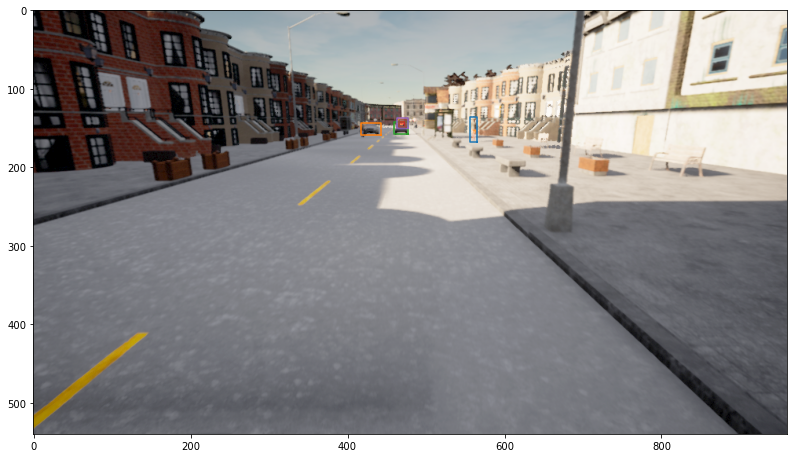

1


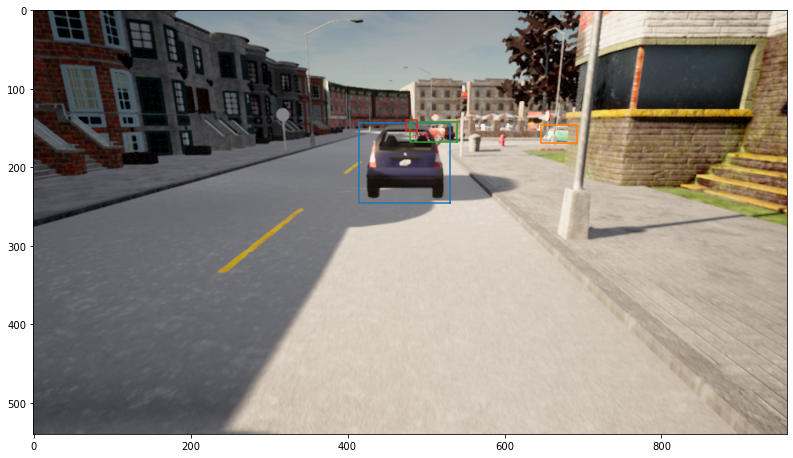

2


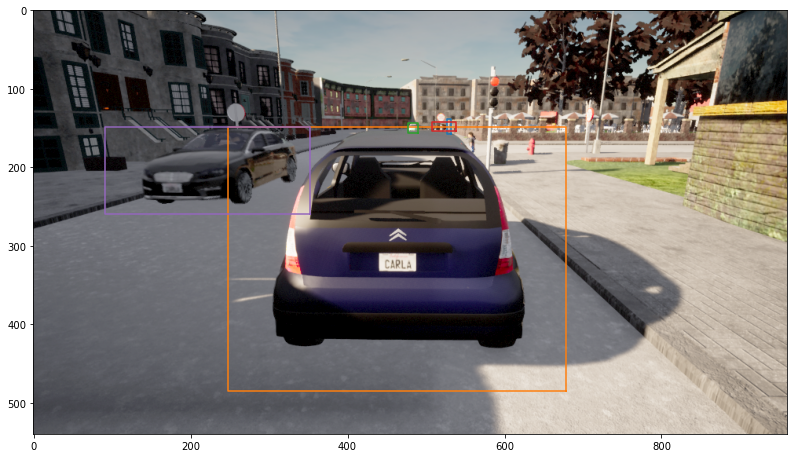

3


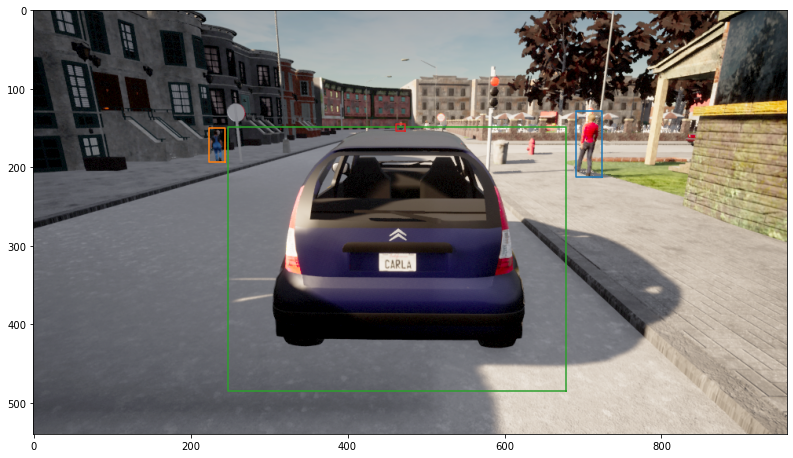

4


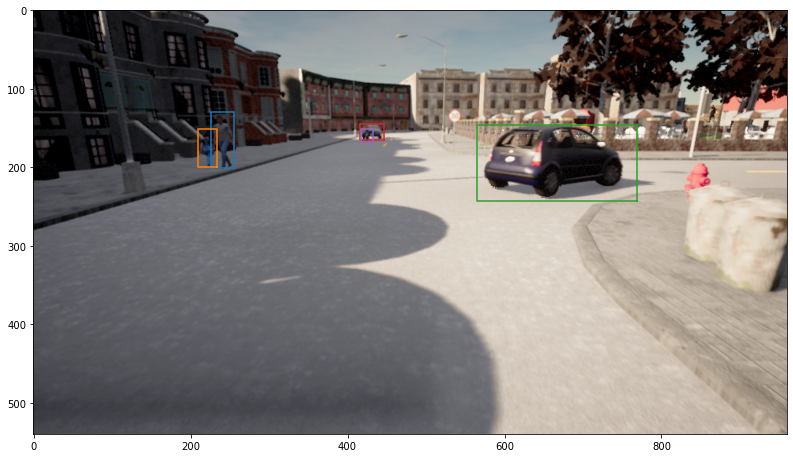

In [247]:
bbox_threshold = 0.3

for i in range(len(image_path)):
    print(i)
    
    plt.figure(figsize = (54/4, 96/4))
    img = read_image(image_path[i])
    seg_img = read_image(seg_image_path[i])
    total_width, total_height = len(img[0]), len(img)

    ped_bboxs = get_box(ped_box_path[i], "Pedestrian")
    for box in ped_bboxs:
        # window에 벗어나는 bbox 삭제
        x1, y1, x2, y2 = box
        if (x1 < 0 and x2 < 0) \
            or (x1 > total_width and x2 > total_width) \
            or (y1 < 0 and y2 < 0) \
            or (y1 > total_height and y2 > total_height):
            continue
        width = x1 - x2 + 1
        height = y1 - y2 + 1
        # 너무 작은 bbox 삭제
        if width <= 5 or height <= 5:
            continue
        # segmentation rate가 0.5 이하인 것 삭제
        if get_seg_rate(seg_img, box, type="Pedestrian") < bbox_threshold:
            continue
        plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1])

    veh_bboxs = get_box(veh_box_path[i], "Vehicles")
    for box in veh_bboxs:
        # window에 벗어나는 bbox 삭제
        x1, y1, x2, y2 = box
        if (x1 < 0 and x2 < 0) \
            or (x1 > total_width and x2 > total_width) \
            or (y1 < 0 and y2 < 0) \
            or (y1 > total_height and y2 > total_height):
            continue
        width = x1 - x2 + 1
        height = y1 - y2 + 1
        # 너무 작은 bbox 삭제
        if width <= 5 or height <= 5:
            continue
        # segmentation rate가 0.5 이하인 것 삭제
        if get_seg_rate(seg_img, box, type="Vehicles") < bbox_threshold:
            continue
        plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1])

    plt.imshow(img)

    plt.show()